In [1]:
#Import libraries
import keras as k
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Load market data
market_train_df = pickle.load( open( "Market_train", "rb" ) )

In [3]:
#Load news data
news_train_df = pickle.load(open("News_train-002", "rb"))

# Preprocessing

### 1. General Preprocessing done for every model

### 2. Extract assetCode and convert to integer labels

### 3. Extra 7 features for Model

### 4. Labels for Regression are : 
-  Original Features 
-  Normalized Features 

### 5. One hot encoded the Regression labels for binary classification using a threshold based on return value



In [4]:
#Preprocess( NO change to asset)
def preprocess_data(mkt_train_df, news_train_df):
    mkt_train_df['time'] = mkt_train_df['time'].dt.date
    news_train_df['time'] = news_train_df['time'].dt.date
    assetCodes = []
    index = 0
    for x in news_train_df['assetCodes']:
        x = x.split(',')[0].split("'")[1]
        assetCodes.append(x)
    news_train_df['assetCode'] = np.asarray(assetCodes)
    irrelevantColumns = ['sourceTimestamp', 'firstCreated', 'sourceId', 
                         'headline', 'provider', 'subjects', 'audiences',
                        'headlineTag', 'marketCommentary', 'assetCodes', 'assetName']
    news_train_df.drop(irrelevantColumns, axis=1, inplace=True)
    market_train_df.drop(['assetName'], axis=1, inplace=True)
    modifiednews = news_train_df.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
    
    # join news reports to market data, note many assets will have many days without news data
    merged = pd.merge(mkt_train_df, modifiednews, how='left', on=['time', 'assetCode'], copy=False) 
    merged = merged.fillna(0)
    merged.drop(['time'], axis=1,inplace= True)
     
    return merged

In [5]:
#Preprocess data
X = preprocess_data(market_train_df, news_train_df)

In [6]:
#Save some memory
del market_train_df, news_train_df

In [7]:
#Get labels and drop that label from X
Y = X['returnsOpenNextMktres10']
X.drop(['returnsOpenNextMktres10'], axis=1, inplace=True)

In [8]:
#Asset code manipulation
ac = X.assetCode
ac = pd.get_dummies(ac)

In [9]:
#Convert ac to labels
ac = ac.values
ac = np.argmax(ac, axis =1)

In [10]:
#convert array to pandas dataframe
ac = pd.DataFrame(ac, columns = ['assetCode'])

In [11]:
#Get all cols 
cols = X.columns
all_feat = cols[2:]

In [12]:
#Get features, concat with labels and fill na values with 0s
X_new = X[['close','open','sentimentClass','sentimentNegative','sentimentNeutral','sentimentPositive']]
X_new = pd.concat((ac,X_new,Y), axis = 1)
X_new.fillna(0)
print('')
print(X_new.head())


   assetCode  close   open  sentimentClass  sentimentNegative  \
0          0  32.19  32.17            0.50           0.080418   
1          2  11.12  11.08            0.25           0.138128   
2          7  37.51  37.99            0.00           0.000000   
3          8  84.74  86.23            0.00           0.000000   
4         15  18.02  18.01            0.00           0.000000   

   sentimentNeutral  sentimentPositive  returnsOpenNextMktres10  
0          0.568264           0.351318                 0.034672  
1          0.412758           0.449114                 0.027803  
2          0.000000           0.000000                 0.024433  
3          0.000000           0.000000                -0.007425  
4          0.000000           0.000000                -0.017994  


In [13]:
#make a copy of full data-set
df_stock =X_new

In [14]:
##### Remove outliers
a = df_stock[df_stock.returnsOpenNextMktres10<1.5]
a = a[a.returnsOpenNextMktres10>-1.5]

In [15]:
#Def normalize if we want to normalize
def normalize(Y):
    max_v = Y.max()
    min_v = Y.min()
    Y = Y - min_v
    denom = max_v - min_v
    Y = Y/denom
    return Y

In [16]:
#select features and label
X = a.iloc[:,0:-1]
Y = a.iloc[:,-1]
X.head()

,assetCode,close,open,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive
0,0,32.19,32.17,0.50,0.080418,0.568264,0.351318
1,2,11.12,11.08,0.25,0.138128,0.412758,0.449114
2,7,37.51,37.99,0.00,0.000000,0.000000,0.000000
3,8,84.74,86.23,0.00,0.000000,0.000000,0.000000
4,15,18.02,18.01,0.00,0.000000,0.000000,0.000000


In [17]:
#Get original values and normalize Y
Y_actual = Y.copy()
Y_norm = normalize(Y_actual)

In [18]:
#Convert to numpy
X = X.values
Y = Y.values

In [162]:
#Convert to binary encodings
Y[Y>0] = 1
Y[Y<0] = 0

In [165]:
from sklearn.model_selection import train_test_split

# Regression model without normalized labels

In [189]:
#Split data for regression without labels normalized(Distribution is between -1 and 1)
X_train_act, X_test_act, Y_train_act, Y_test_act = train_test_split(X, Y_actual, test_size=0.1, random_state=42)

In [198]:
#define model for regression without normalizing labels
def build_model(lre):
    model = k.Sequential()
    model.add(k.layers.Dense(units=128, activation='relu',input_dim = 7))
    model.add(k.layers.Dense(units = 1024, activation = 'relu'))
    model.add(k.layers.Dense(units = 2058, activation = 'relu'))
    model.add(k.layers.Dense(units = 1024, activation = 'sigmoid'))
    model.add(k.layers.Dense(units = 1, activation = 'linear'))
    adam_o = k.optimizers.Adamax(lr=lre)
    rms = k.optimizers.RMSprop(lr=lre)
    model.compile(optimizer = rms, loss = 'mean_squared_error', metrics=['mae'])
    model.summary()
    return model

In [191]:
model = build_model(0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 128)               1024      
_________________________________________________________________
dense_113 (Dense)            (None, 1024)              132096    
_________________________________________________________________
dense_114 (Dense)            (None, 2058)              2109450   
_________________________________________________________________
dense_115 (Dense)            (None, 1024)              2108416   
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 1025      
Total params: 4,352,011
Trainable params: 4,352,011
Non-trainable params: 0
_________________________________________________________________


In [192]:
#Fit model with Regression data with tensorboard callback
tb = k.callbacks.TensorBoard(log_dir='./ANNREG', batch_size=200000, write_graph=True, update_freq='epoch')
history = model.fit(X_train_act,Y_train_act,batch_size=200000,epochs=10,verbose = 1, validation_data=(X_test_act,Y_test_act), callbacks=[tb])

Train on 3665177 samples, validate on 407242 samples
Epoch 1/10
3665177/3665177 [==============================] - 12s 3us/step - loss: 34.3075 - mean_absolute_error: 2.3760 - val_loss: 0.0049 - val_mean_absolute_error: 0.0461
Epoch 2/10
3665177/3665177 [==============================] - 12s 3us/step - loss: 0.0049 - mean_absolute_error: 0.0461 - val_loss: 0.0049 - val_mean_absolute_error: 0.0460
Epoch 3/10
3665177/3665177 [==============================] - 12s 3us/step - loss: 0.0049 - mean_absolute_error: 0.0463 - val_loss: 0.0060 - val_mean_absolute_error: 0.0558
Epoch 4/10
3665177/3665177 [==============================] - 12s 3us/step - loss: 0.0516 - mean_absolute_error: 0.1998 - val_loss: 0.1063 - val_mean_absolute_error: 0.3187
Epoch 5/10
3665177/3665177 [==============================] - 12s 3us/step - loss: 0.0666 - mean_absolute_error: 0.2466 - val_loss: 0.0533 - val_mean_absolute_error: 0.2217
Epoch 6/10
3665177/3665177 [==============================] - 11s 3us/step - loss

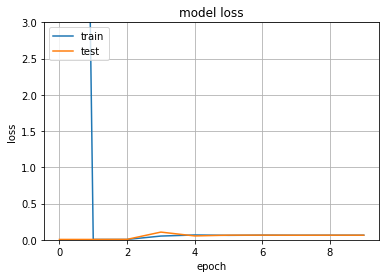

In [196]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylim(0,3)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('ANN-NONORMALIZE')
plt.show()

# Regression model with normalized labels

In [197]:
#Split into train test
X_train_act, X_test_act, Y_train_act, Y_test_act = train_test_split(X, Y_norm, test_size=0.1, random_state=42)

In [203]:
#
model = build_model(0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_122 (Dense)            (None, 128)               1024      
_________________________________________________________________
dense_123 (Dense)            (None, 1024)              132096    
_________________________________________________________________
dense_124 (Dense)            (None, 2058)              2109450   
_________________________________________________________________
dense_125 (Dense)            (None, 1024)              2108416   
_________________________________________________________________
dense_126 (Dense)            (None, 1)                 1025      
Total params: 4,352,011
Trainable params: 4,352,011
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fit model with Regression data with tensorboard callback
tb = k.callbacks.EarlyStopping(monitor='val_loss',  patience=5, verbose=1, restore_best_weights=True)
history = model.fit(X_train_act,Y_train_act,batch_size=200000,epochs=30,verbose = 1, validation_data=(X_test_act,Y_test_act), callbacks=[tb])

Train on 3665177 samples, validate on 407242 samples
Epoch 1/30
 600000/3665177 [===>..........................] - ETA: 16s - loss: 198.3249 - mean_absolute_error: 11.6867

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()